In [1]:
import boto3
import numpy as np
from IPython.core.display import HTML

In [ ]:
region = boto3.Session().region_name
s3_bucket = f"storage.platinumj"
s3 = boto3.client(
    "s3", 
    region_name='eu-north-1',
    aws_access_key_id='',
    aws_secret_access_key=''
    )

In [4]:
def download_from_s3(key_filenames):
    for key_filename in key_filenames:
        s3.download_file(s3_bucket, key_filename, key_filename)
        
img_jpg = "12595907-12c0-4e15-8c1f-6dacd1a1e2ec"
download_from_s3(key_filenames=[img_jpg])

HTML('<img src="Naxos_Taverna.jpg" alt="Naxos_Taverna" style="height: 600px;"/>'
     '<figcaption>Naxos_Taverna.jpg</figcaption>The image has been downloaded from '
     'https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg, '
     '<a href="https://en.wikipedia.org/wiki/GNU_Free_Documentation_License">License</a>')


In [ ]:
import json
def query_endpoint(input_img):
    endpoint_name = 'jumpstart-dft-mx-od-yolo3-mobilenet-20241112-104251'
    client = boto3.client(
        'runtime.sagemaker',
        region_name='us-east-1',
    aws_access_key_id='',
    aws_secret_access_key=''
    )
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=input_img, Accept='application/json;verbose;n_predictions=20')
    # If we remove ';n_predictions=20' from Accept, we get all the predicted boxes.  
    model_predictions = json.loads(response['Body'].read())
    return model_predictions

def parse_response(model_predictions):    
    normalized_boxes, classes, scores, labels = model_predictions['normalized_boxes'], model_predictions['classes'], model_predictions['scores'], model_predictions['labels']
    # Substitute the classes index with the classes name
    class_names = [labels[int(idx)] for idx in classes]
    return normalized_boxes, class_names, scores


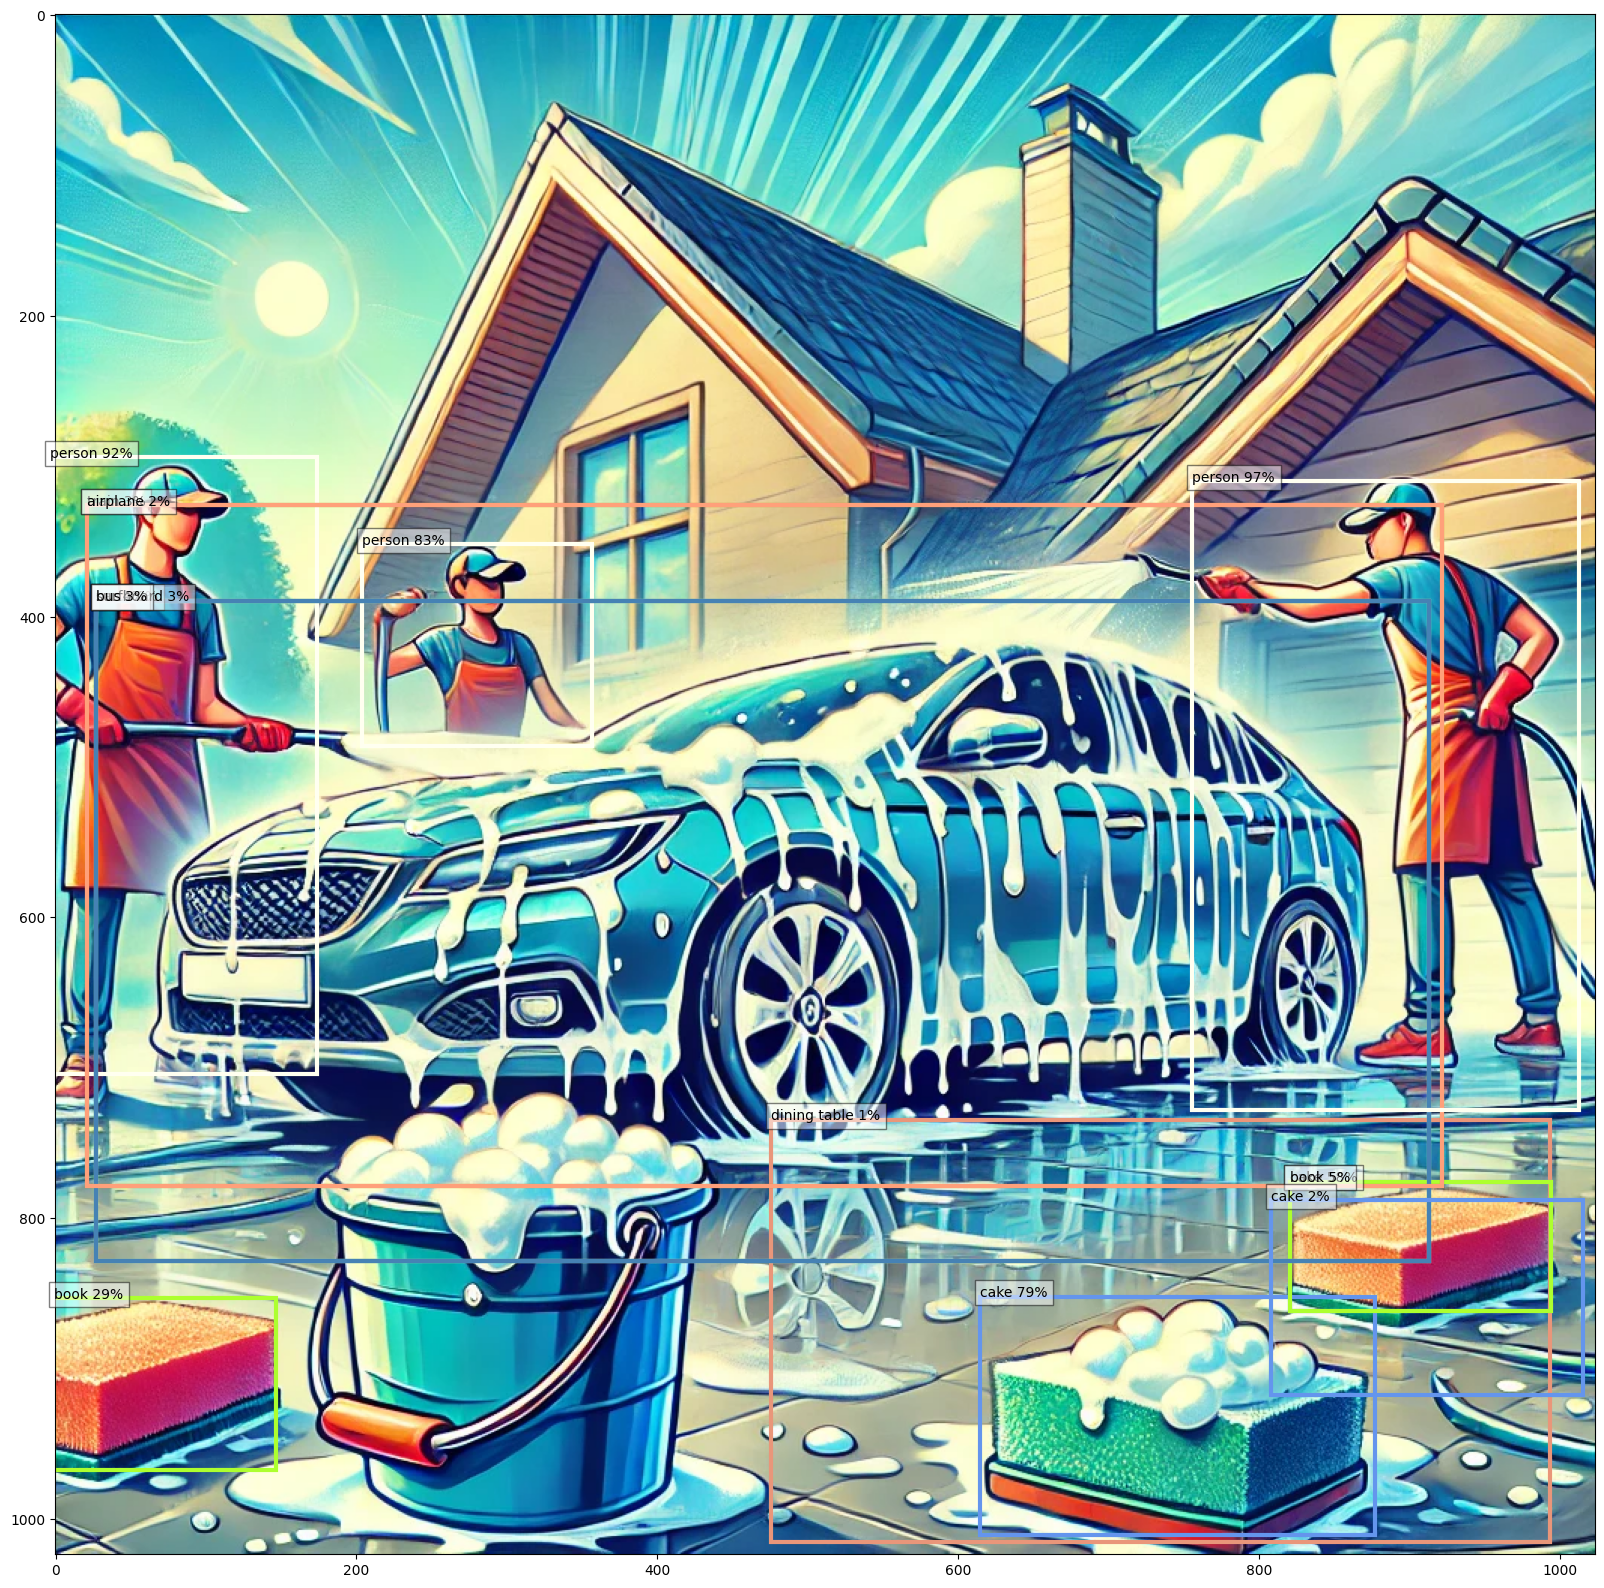

In [6]:

with open(img_jpg, 'rb') as file: input_img = file.read()
best_results_per_input = parse_response(query_endpoint(input_img))
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageColor
colors = list(ImageColor.colormap.values())

image_np = np.array(Image.open(img_jpg))
plt.figure(figsize=(20,20))
ax = plt.axes()
ax.imshow(image_np)
normalized_boxes, classe_names, confidences = best_results_per_input
for idx in range(len(normalized_boxes)):
    left, bot, right, top = normalized_boxes[idx]
    x, w = [val * image_np.shape[1] for val in [left, right - left]]
    y, h = [val * image_np.shape[0] for val in [bot, top - bot]]
    color = colors[hash(classe_names[idx]) % len(colors)]
    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, "{} {:.0f}%".format(classe_names[idx], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()